# Explainable **CNN** on FashionMNIST Dataset
## by **[Abolfazl Mohajeri](https://abolfazlmohajeri.ir)**

In [ ]:
%matplotlib inline

### 1. Load and normalize FashionMNIST

Using ``torchvision``, it’s extremely easy to load FashionMNIST.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# ToTensor(): Converts Python Imaging Library (PIL) images into tensors to be used in CNN
transform = transforms.ToTensor()

# Load dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# Training samples in one iteration
# You can try changing the batch_size to be larger!
batch_size = 1

# Prepare data loaders, num_workers is for parallel calculation
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Images classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Train data, number of images:  60000
Test data, number of images:  10000


Let us show one of the training image, for fun.



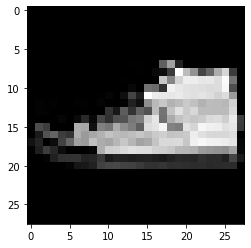

Sneaker


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training image
dataiter = iter(trainloader)
image, label = dataiter.next()

# Show image
imshow(torchvision.utils.make_grid(image))
# Print labels
print(' '.join(f'{classes[label[j]]:5s}' for j in range(batch_size)))

Each image in this dataset is a 28x28 pixel, normalized, grayscale image.

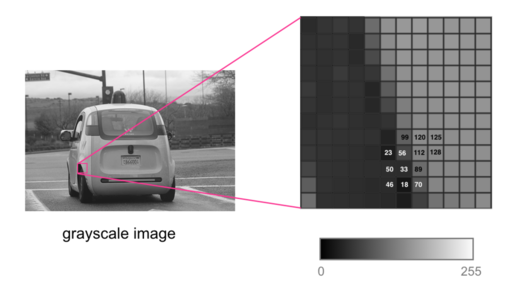

### 2. Define a Convolutional Neural Network



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        filters_1 = 10
        self.conv1 = nn.Conv2d(1, filters_1, 3)
        # Pooling layer that reduces the size of the image by 2
        self.pool1 = nn.MaxPool2d(2, 2)
        # Second convolutional layer that increases the number of filtered outputs
        filters_2 = 20
        self.conv2 = nn.Conv2d(filters_1, filters_2, 3)
        # Another pooling layer
        self.pool2 = nn.MaxPool2d(2, 2)
        # Finally, a full-connected linear layer
        self.fc1 = nn.Linear(filters_2*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # Flatten the output of the final pooling layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Our model is like this:

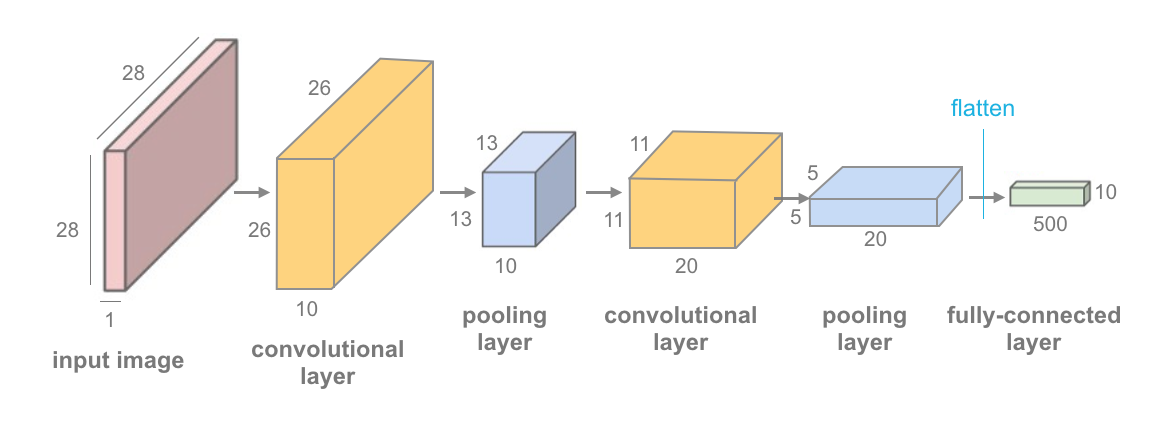

For better understanding of input, filter, convolution and feature map:

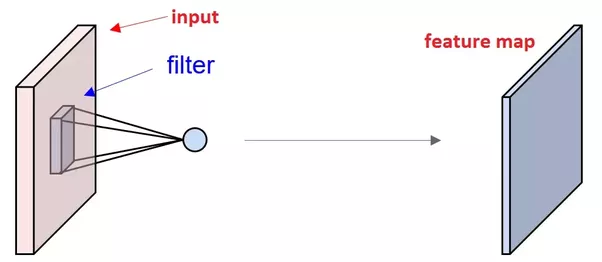

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs, data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter (weight) gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        # Outputs is predicted class and labels is the correct class
        loss = loss_function(outputs, labels)
        # backward() perform backpropagation by computing the gradient based on the loss
        loss.backward()
        # step() iterates over all the parameters and update their values
        optimizer.step()
        # Print loss statistics
        # item() extracts the loss’s value as a Python float
        running_loss += loss.item()
        # Print every 1000 mini-batches
        if i % 10000 == 9999:
            print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, i+1, running_loss/1000))
            running_loss = 0.0
    print()
print('Training is finished')

Epoch: 1, Batch: 10000, Avg. Loss: 9.17091071618547
Epoch: 1, Batch: 20000, Avg. Loss: 5.4773766292189645
Epoch: 1, Batch: 30000, Avg. Loss: 4.922164781316794
Epoch: 1, Batch: 40000, Avg. Loss: 4.554197305595174
Epoch: 1, Batch: 50000, Avg. Loss: 4.431050961687815
Epoch: 1, Batch: 60000, Avg. Loss: 4.206213169804537

Epoch: 2, Batch: 10000, Avg. Loss: 3.9199018750429238
Epoch: 2, Batch: 20000, Avg. Loss: 3.7270708382846442
Epoch: 2, Batch: 30000, Avg. Loss: 3.8114727125331087
Epoch: 2, Batch: 40000, Avg. Loss: 3.611364912760909
Epoch: 2, Batch: 50000, Avg. Loss: 3.541007677186224
Epoch: 2, Batch: 60000, Avg. Loss: 3.5841168989703567

Training is finished



### 5. Test the network on the test data



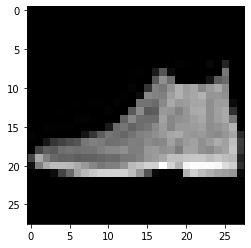

GroundTruth:  Ankle boot
Predicted:  Ankle boot


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', classes[labels])
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', classes[predicted])

The results seem pretty good.

Let us look at how the network performs on the whole dataset:

**Accuracy** is how close or far off a given set of measurements are to their true value.

In [ ]:
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Set the module to evaluation mode
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'\nAccuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 86 %
Accuracy for class: T-shirt/top is 81.3 %
Accuracy for class: Trouser is 96.9 %
Accuracy for class: Pullover is 75.5 %
Accuracy for class: Dress is 90.8 %
Accuracy for class: Coat  is 65.0 %
Accuracy for class: Sandal is 97.3 %
Accuracy for class: Shirt is 67.5 %
Accuracy for class: Sneaker is 94.8 %
Accuracy for class: Bag   is 98.2 %
Accuracy for class: Ankle boot is 94.3 %



### 6. Explainability

In [ ]:
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import LRP
from captum.attr import visualization as viz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**With IG**

Label:  Ankle boot
Predicted:  Ankle boot


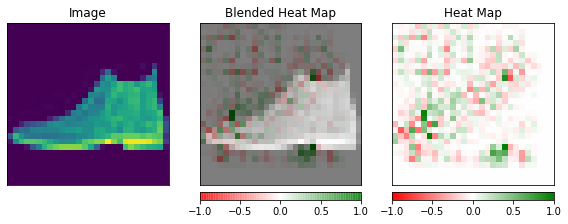

Label:  Pullover
Predicted:  Pullover


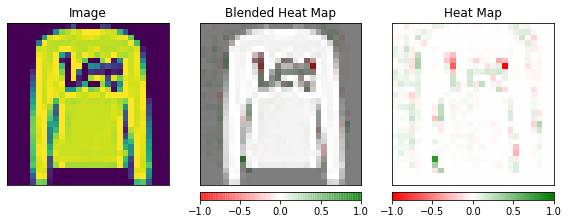

Label:  Trouser
Predicted:  Trouser


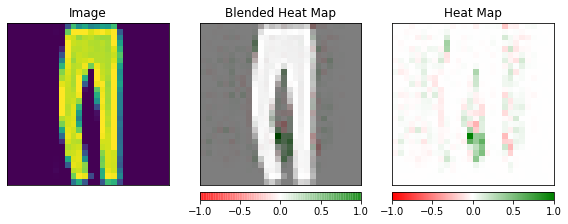

Label:  Trouser
Predicted:  Trouser


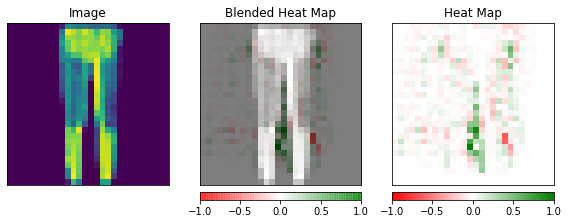

Label:  Shirt
Predicted:  T-shirt/top


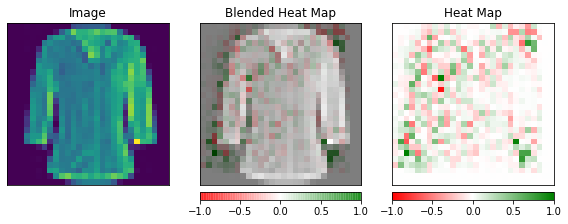

Label:  Trouser
Predicted:  Trouser


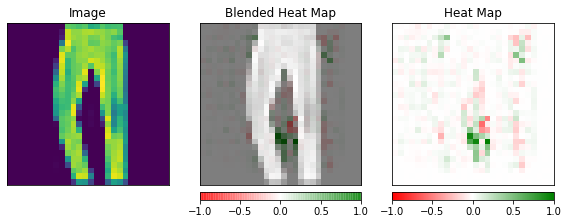

Label:  Coat
Predicted:  Shirt


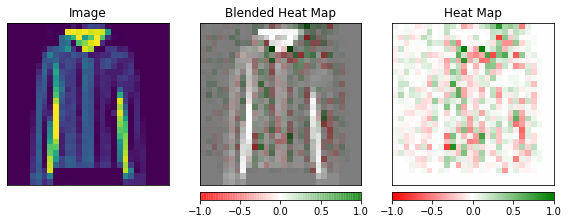

Label:  Shirt
Predicted:  Shirt


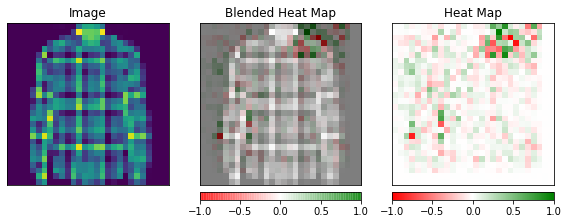

Label:  Sandal
Predicted:  Sandal


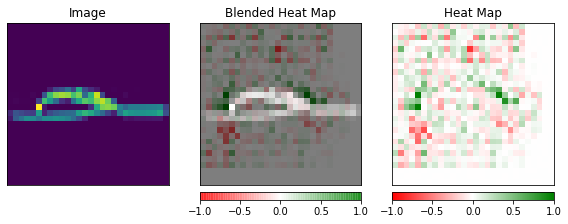

Label:  Sneaker
Predicted:  Sneaker


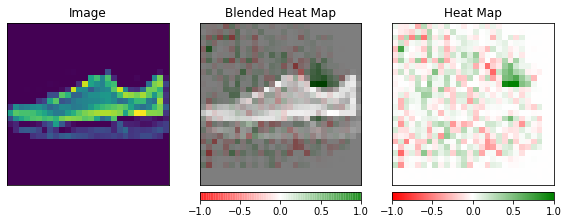

Label:  Coat
Predicted:  Coat


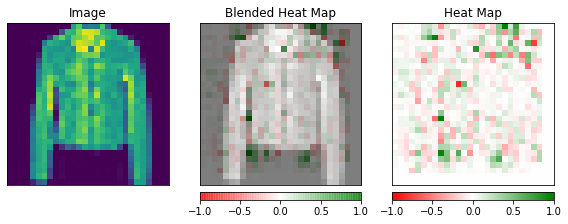

Label:  Sandal
Predicted:  Sandal


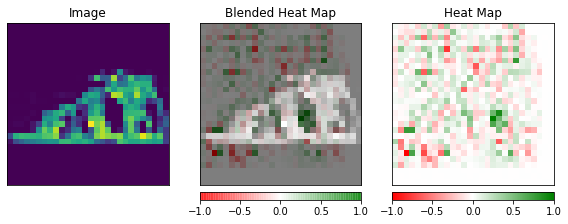

Label:  Sneaker
Predicted:  Sneaker


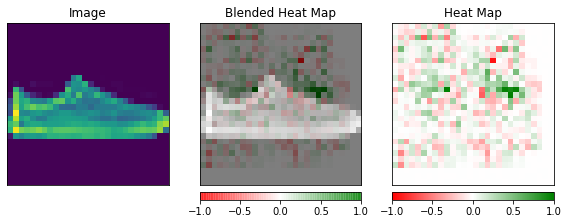

Label:  Dress
Predicted:  Dress


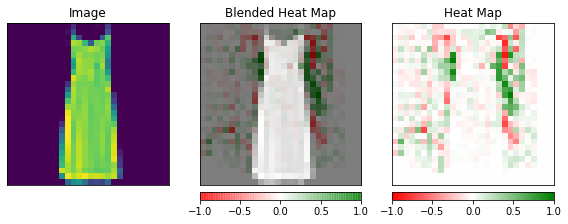

Label:  Coat
Predicted:  Coat


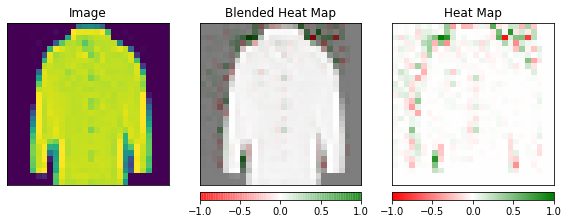

In [ ]:
dataiter = iter(testloader)
for x in range(15):
  images, labels = dataiter.next()
  print('Label: ', classes[labels])
  images, labels = images.to(device), labels.to(device)
  outputs = net(images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', classes[predicted])
  # baseline = torch.zeros([1, 1, 28, 28], dtype=torch.int32).to(device)
  baseline = torch.ones([1, 1, 28, 28], dtype=torch.int32).to(device)
  # baseline = torch.full((1, 1, 28, 28), 0.5).to(device)
  attr_algo = IntegratedGradients(net)
  attrs = attr_algo.attribute(images, target = labels, baselines=baseline)
  viz.visualize_image_attr_multiple(
    attr=np.reshape(attrs.squeeze().cpu().detach().numpy(), attrs.squeeze().cpu().detach().numpy().shape+(1,)),
    original_image=np.reshape(images.squeeze().cpu().detach().numpy(), images.squeeze().cpu().detach().numpy().shape+(1,)),
    methods=["original_image", "blended_heat_map", "heat_map"],  
    signs=["all", "all", "all"],
    titles=["Image", "Blended Heat Map", "Heat Map"],
    show_colorbar=True
  )

**With LRP**

Label:  Ankle boot
Predicted:  Ankle boot


/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


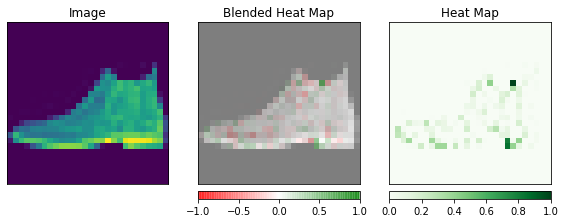

Label:  Pullover
Predicted:  Pullover


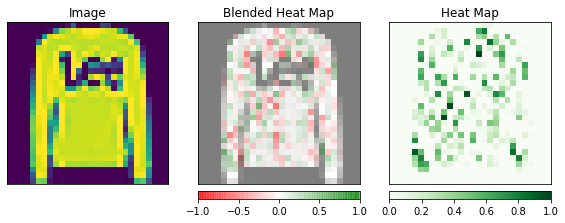

Label:  Trouser
Predicted:  Trouser


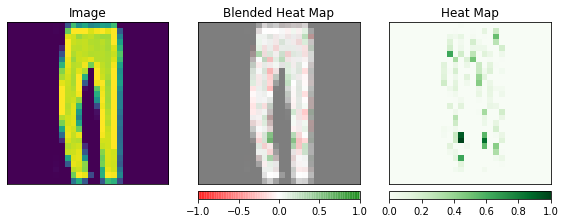

Label:  Trouser
Predicted:  Trouser


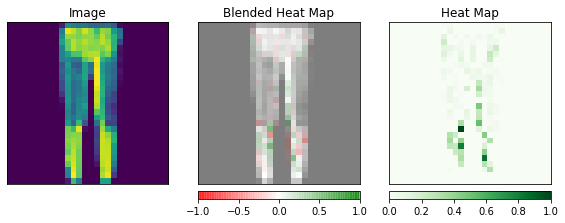

Label:  Shirt
Predicted:  T-shirt/top


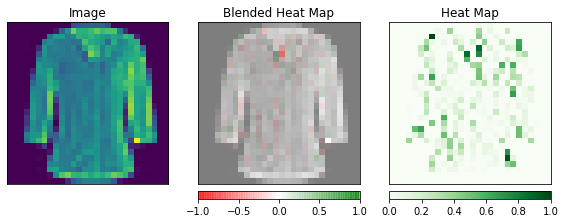

Label:  Trouser
Predicted:  Trouser


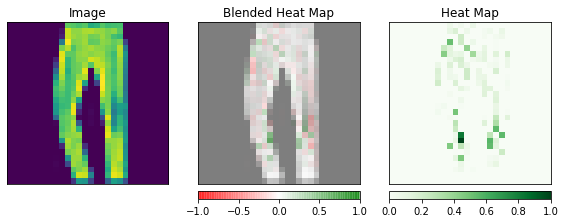

Label:  Coat
Predicted:  Shirt


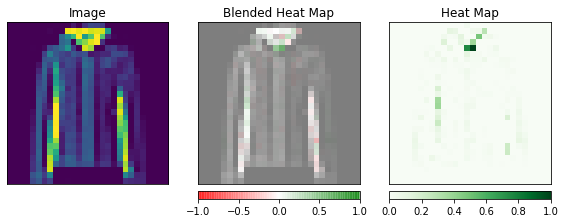

Label:  Shirt
Predicted:  Shirt


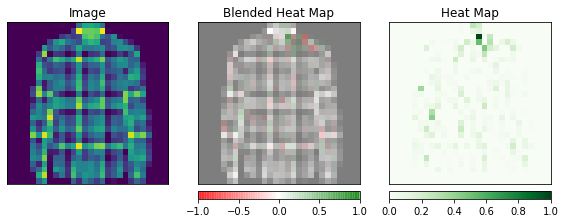

Label:  Sandal
Predicted:  Sandal


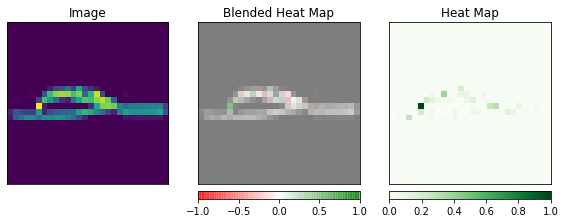

Label:  Sneaker
Predicted:  Sneaker


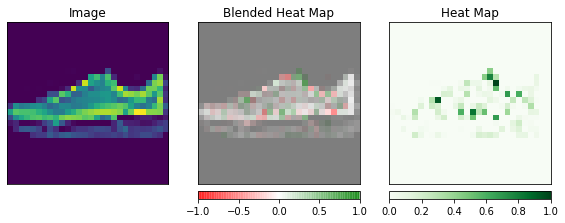

Label:  Coat
Predicted:  Coat


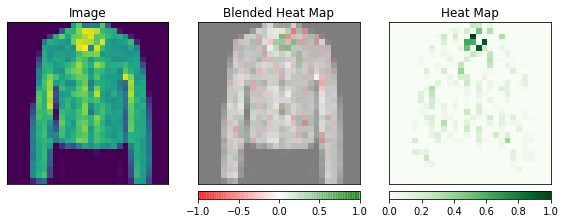

Label:  Sandal
Predicted:  Sandal


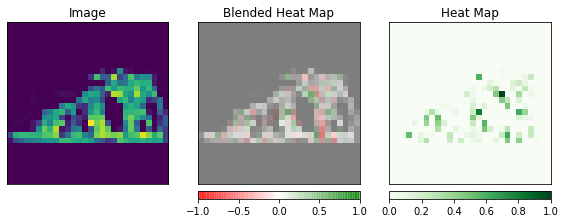

Label:  Sneaker
Predicted:  Sneaker


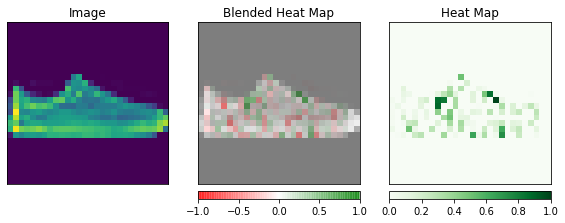

Label:  Dress
Predicted:  Dress


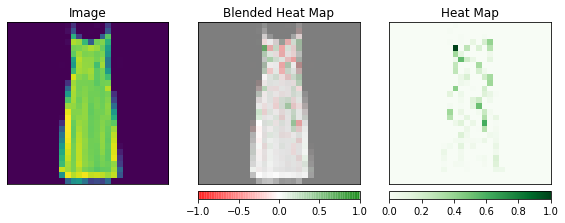

Label:  Coat
Predicted:  Coat


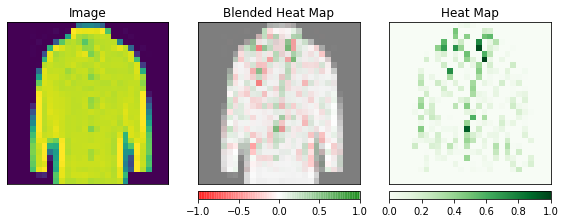

In [ ]:
dataiter = iter(testloader)
for x in range(15):
  images, labels = dataiter.next()
  print('Label: ', classes[labels])
  images, labels = images.to(device), labels.to(device)
  outputs = net(images)
  _, predicted = torch.max(outputs, 1)
  print('Predicted: ', classes[predicted])
  attr_algo = LRP(net)
  attrs = attr_algo.attribute(images, target = labels)
  viz.visualize_image_attr_multiple(
    attr=np.reshape(attrs.squeeze().cpu().detach().numpy(), attrs.squeeze().cpu().detach().numpy().shape+(1,)),
    original_image=np.reshape(images.squeeze().cpu().detach().numpy(), images.squeeze().cpu().detach().numpy().shape+(1,)),
    methods=["original_image", "blended_heat_map", "heat_map"],  
    signs=["all", "all", "positive"],
    titles=["Image", "Blended Heat Map", "Heat Map"],
    show_colorbar=True
  )